In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv, OptimalPlayer
%matplotlib inline

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [3]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [4]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [5]:
env.render()

|- - -|
|- - -|
|- - -|



### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [6]:
env.step(2)

(array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 False,
 None)

In [7]:
env.render()

|- - X|
|- - -|
|- - -|



In [8]:
env.__dict__

{'grid': array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 1,
 'current_player': 'O'}

In [9]:
env.step((1,1))

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [10]:
env.render()

|- - X|
|- O -|
|- - -|



In [11]:
env.__dict__

{'grid': array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 2,
 'current_player': 'X'}

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [12]:
env.step((0,2))

ValueError: There is already a chess on position (0, 2).

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [13]:
env.observe()

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [14]:
env.reward(player='X')

0

In [15]:
env.reward(player='O')

0

An example of finishing the game:

In [16]:
env.step(0)
env.step(3)
env.step(1)

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [17]:
env.render()

|X X X|
|O O -|
|- - -|



In [18]:
env.observe()

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [19]:
env.reward(player='X')

1

In [20]:
env.reward(player='O')

-1

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [21]:
env.reset();

In [22]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [23]:
opt_player.act(env.grid)

(1, 1)

In [24]:
opt_player.player

'X'

### An example of optimal player playing against random player

In [25]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|O O O|
|- X -|
|- X X|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|O X -|
|- O X|
|- X O|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|- O X|
|- X -|
|X O -|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|- X O|
|- O X|
|O - X|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|O - X|
|- O X|
|X - O|



### An example of optimal player playing against optimal player

In [26]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X O X|
|O X X|
|O X O|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X X O|
|O O X|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|X O X|
|O O X|
|X X O|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|X X O|
|O O X|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|X O X|
|X O O|
|O X X|



## *Q*-Learning

### 2.1 Learning from experts

In [118]:
# Constants
ALPHA = 0.05
GAMMA = 0.99
EPSILON = 0.3 # Arbitrary
E_MIN = 0.1
E_MAX = 0.8

# Helpers

def encode(S, A):
    ''' Unique encoder for a given state-action pair \n
        Params: 
            S: Represents the current state
               TictactoeEnv object
            A: Represents the action to be taken
               Either Tuple[Int] or Int
    '''
    if isinstance(A, tuple):
        A = A[0] * 3 + A[1]
    return f'{S.grid.reshape(9)}:{A}'

def get_legal_moves(S):
    ''' Helper for getting legal moves given state S \n
        Params:
            S: Current state
               TictactoeEnv object
    '''
    legal_moves = []
    for i in range(9):
        if S.check_valid(i):
            legal_moves.append(i)
    return legal_moves


# TODO: Can be extended to take different policies. Currently only epsilon-greedy 
def choose_action(S, e, Q_values):
    """ Choose next action given current state, epsilon and saved states \n
        Params: 
            S: Current state
               TictactoeEnv object
            e: Epsilon value in range [0, 1]
               Float
            Q_values: Saved Q-values
               Dict(String, Int) -> TODO: Maybe Float

    """
    actions = get_legal_moves(S)
    if np.random.uniform(0, 1) <= e:
        i = np.random.choice(len(actions))
        return actions[i]
    else:
        value_max = -9999
        for a in actions:
            # Get Q(S, a) from saved, or 0 if not encountered
            value = Q_values.get(encode(S, a), 0)
            if value > value_max:
                value_max = value
                A = a
        return A


In [212]:
def test(Q_values, rand, e=0):
    ''' Function for computing M_opt and M_rand \n
        Params:
            Q_values: Q_values derived from a policy, dict[str, float]
            rand: True if calculating M_rand and False if calculating M_opt, boolean
            e: Exploration level, should be zero, int
    '''
    rewards = []
    S = TictactoeEnv()
    for i in range(500): # Fixed number of test games
        np.random.seed(i) # Different seed for each iteration
        # int(False) = 0 => optimal player, else random player
        p = OptimalPlayer(int(rand), 'O') if i % 2 == 0 else OptimalPlayer(int(rand), 'X')
        while not S.end:
            if S.current_player != p.player:
                A = choose_action(S, e, Q_values)
            else:
                A = p.act(S.grid)

            grid, end, winner = S.step(A)
            if end:
                # 1 if policy wins, -1 if policy loses, else 0
                R = - S.reward(player=p.player)
                rewards.append(R)
                S.reset()
                # if winner == p.player and winner is not None and not rand:
                #     print(f'Optimal player: {p.player}, Winner: {S.winner}, Reward: {R}')
                #     S.render()
                break

    return sum(rewards)  / len(rewards)

# Function for training
def train(N, e=0.1, e_opt=0.5, compute_every=250, decrease_epsilon=False, dec_factor=1, 
          compute_tests=False):
    """ Function for training a policy Sarsa (TODO: Expand to other algorithm if needed) \n
        Params:
            N: Number of games, int
            e: Epsilon value, float in [0, 1]
            e_opt: Epsilon value for OptimalPlayer, float in [0, 1]
            compute_every: Number of games before compute training and test average, int
            decrease_epsilon: True if epsilon should be decreased each game, boolean
            dec_factor: Decreasing factor for epsilon, int
            compute_tests: True if M_opt and M_rand should be computed, boolean
    """
    Q_values = {}
    S = TictactoeEnv() # Init env
    avg_rewards = []
    curr_rewards = []
    m_opt, m_rand = [], []
    for i in range(N): 
        if i % 5000 == 0:
            print(f'Starting game {i}')
        # Compute reward (and test)
        if i % compute_every == 0 and i > 0:
            avg_rewards.append(np.mean(curr_rewards))
            curr_rewards = []
            if compute_tests:
                m_opt.append(test(Q_values, False))
                m_rand.append(test(Q_values, True))
        # Decrease epsilon
        if decrease_epsilon:
            e = max(E_MIN, E_MAX*(1 - i / dec_factor))

        # Switch starting player
        opt = OptimalPlayer(e_opt, 'O') if i % 2 == 0 else OptimalPlayer(e_opt, 'X')

        # Keep track of explroed Q-values
        explored_Q = []
        
        # Play game
        while not S.end:
            
            # Our turn
            if S.current_player != opt.player:
                A = choose_action(S, e, Q_values)
                Q_current = encode(S, A)
                explored_Q.append(Q_current)

            # Optimal algorithm's turn
            else: 
                A = opt.act(S.grid)

            # Perform action 
            grid, end, winner = S.step(A)
            if end:
                R = - S.reward(player=opt.player) # Negative of other players reward
                curr_rewards.append(R) # Store reward
                next_Q = None
                # Backward propagate the reward through our state-action pairs
                for Q in reversed(explored_Q):
                    value = Q_values.get(Q, 0)
                    if next_Q is None:
                        Q_values[Q] = value + ALPHA * (R - value)
                    else:
                        Q_values[Q] = value + ALPHA * (R + GAMMA * next_Q - value)
                    next_Q = Q_values[Q]
                # S.render()

                # Reset and start new game
                S.reset()
                break
    return [0] + avg_rewards, [0] + m_opt, [0] + m_rand

def plot_subplots(rows, cols, x, ys, hyperparam, suptitle, 
                  xlabel, ylabel, labels=[], legend_title='', subtitle=''):
    """ Function for plotting subplots
        Params: 
            (rows, cols): subplot format, (int, int)
            x: values of x-axis, iterable
            ys: values to be plotted, ndarray. MUST have shape: (num_subplots, num_labels, len(x))
                Example: If plotting both M_opt and M_rand in each subplots, num_labels=2
            hyperparam: Hyperparameter that differs over subplots, float
            suptitle: Super title, string
            xlabel: Label of x-axis, string
            ylabel: Label of y-axis, string
            labels: Labels, optional iterable of length num_labels
            legend_title: Optional legend title, str
            subtitle: optional (generic) subtitle of each subplot, is combined with hyperparam. string. 
    """

    fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)
    axs = axs.flatten()

    # Reveal x-ticks and y-ticks on all subplots -> Doesnt work
    for ax in axs:
        for (x_tick, y_tick) in zip(ax.get_xticklabels(), ax.get_yticklabels()):
            x_tick.set_visible(True)
            y_tick.set_visible(True)

    # Plot
    plt.suptitle(suptitle, fontsize=30)
    for i, (hp, y) in enumerate(zip(hyperparam, ys)):
        for reward in y:   
            sns.lineplot(x=x, y=reward, ax=axs[i])
        axs[i].set_title(f'{subtitle} = {hp}', fontsize=24)
        if labels != []:
            axs[i].legend(title=legend_title, labels=labels, loc='lower right')

    fig.text(0.5, 0.04, xlabel, ha='center', fontsize=26)
    fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)

#### Question 1

-> Used sanity check opt = OptimalPlayer(0, _)
TODO: Add caption

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


Text(0, 0.5, 'Avg. reward for past 250 games')

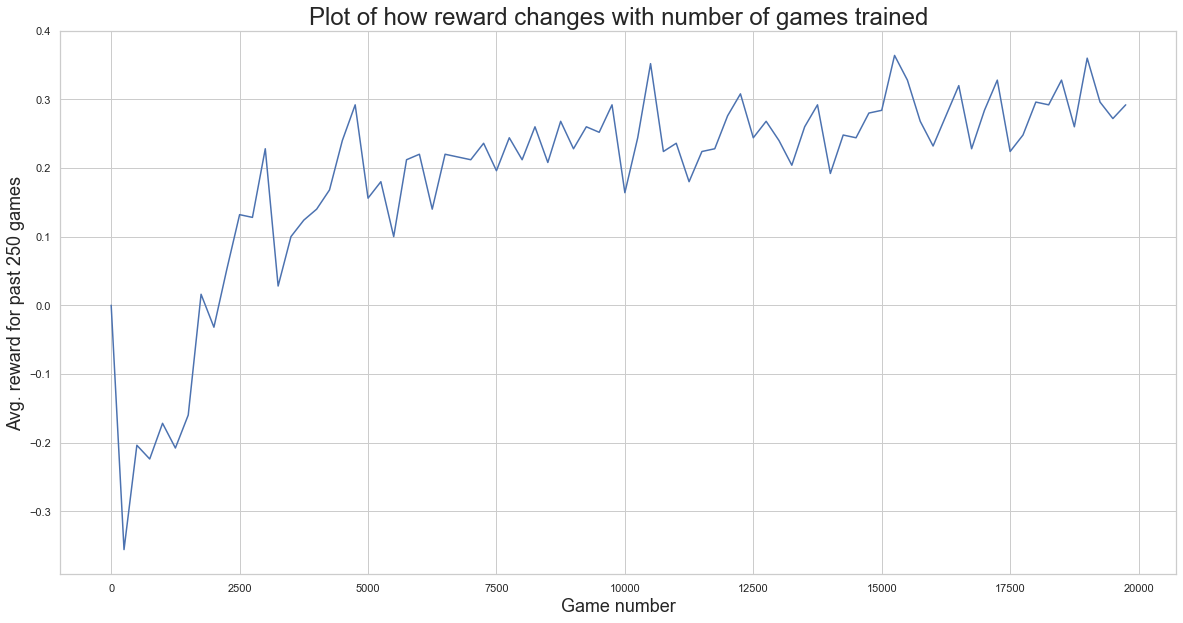

In [164]:
rewards, _, _ = train(20000, e=0.1)

fig = plt.figure(figsize=(20, 10))
sns.set_theme(style='whitegrid')
X = np.linspace(0, 19750, 20000 // 250)
sns.lineplot(x=x, y=rewards)
plt.title('Plot of how reward changes with number of games trained', fontsize=24)
plt.xlabel('Game number', fontsize=18)
plt.ylabel('Avg. reward for past 250 games', fontsize=18)
    


### 2.1.1 Decreasing exploration

#### Question 2

In [ ]:
### 2.1.1 Decreasing exploration
# Eight different values of the decrease factors
dec_factors = [1] + [i * 5000 for i in range(1, 9)]
rewards = []

for dec_factor in dec_factors:
    dec_rewards, _, _ = train(20000, dec_factor=dec_factor, decrease_epsilon=True)
    rewards.append(dec_rewards)

# Expand dims for plotting function
rewards = np.expand_dims(rewards, 1)

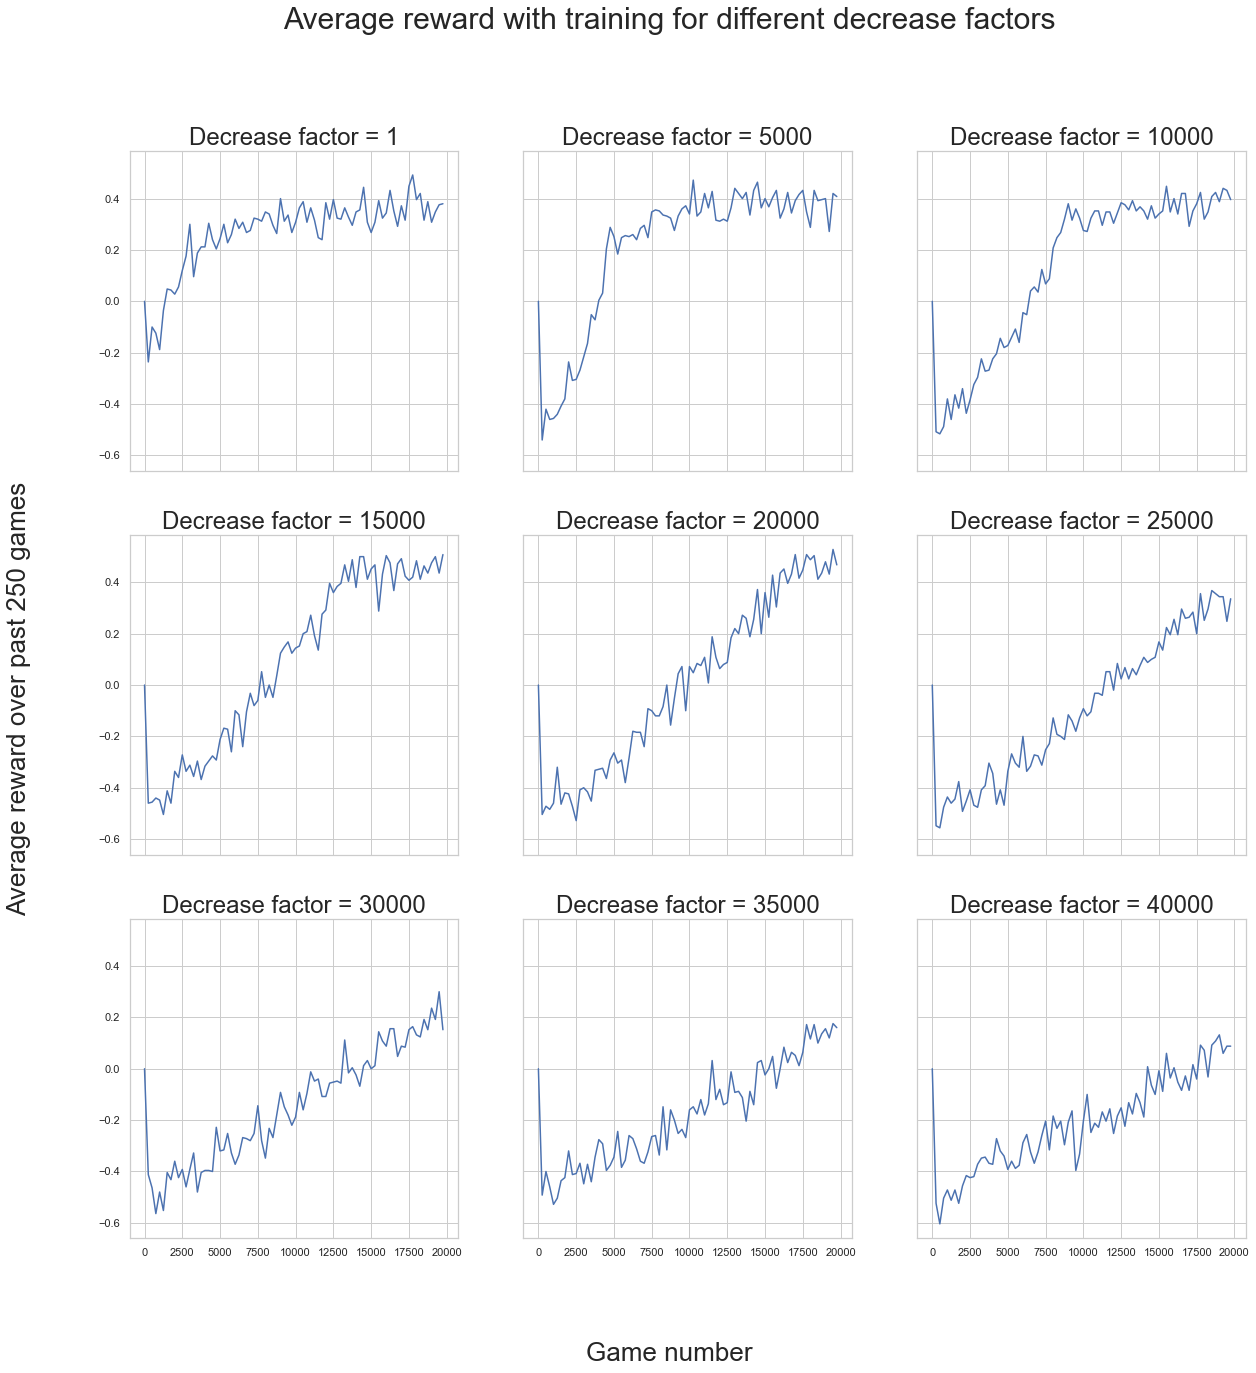

In [305]:
suptitle = 'Average reward with training for different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
#rewards = np.expand_dims(rewards, 1)
plot_subplots(3, 3, X, rewards, dec_factors, suptitle, 
              xlabel, ylabel, subtitle=subtitle)

The larger $n^*$ is, the longer the algorithm stays in 'exploration' mode, i.e. it will keep a higher value of $\epsilon$ for a longer time. From the plots above it is clear that as $n^*$ grows, the speed of which the algorithm converges slows down. For the $n^* \in [15000, 20000]$, the convergence speed is lower than for the smaller $n^*$, but the eventual reward is larger. 

The correct choice of $\epsilon$ helps training. For the example above, $n^* \in [1, 5000, 10000]$ greatly speeds up training, while $n^* \in [15000, 20000, 25000]$ seems to increase convergence treshold. Larger values of $\epsilon$ slows down training, as the algorithm has a higher emphasize on exploration.

#### Question 3

In [221]:
# Same as above
dec_factors = [1] + [i * 5000 for i in range(1, 9)]
m_opts, m_rands = [], []

for dec_factor in dec_factors:
    _, m_opt, m_rand = train(20000, dec_factor=dec_factor, decrease_epsilon=True, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Format and stack along axis=1
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)
m = np.hstack([m_opts, m_rands], axis=0)

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


Text(0.04, 0.5, 'Avg. reward for past 250 games')

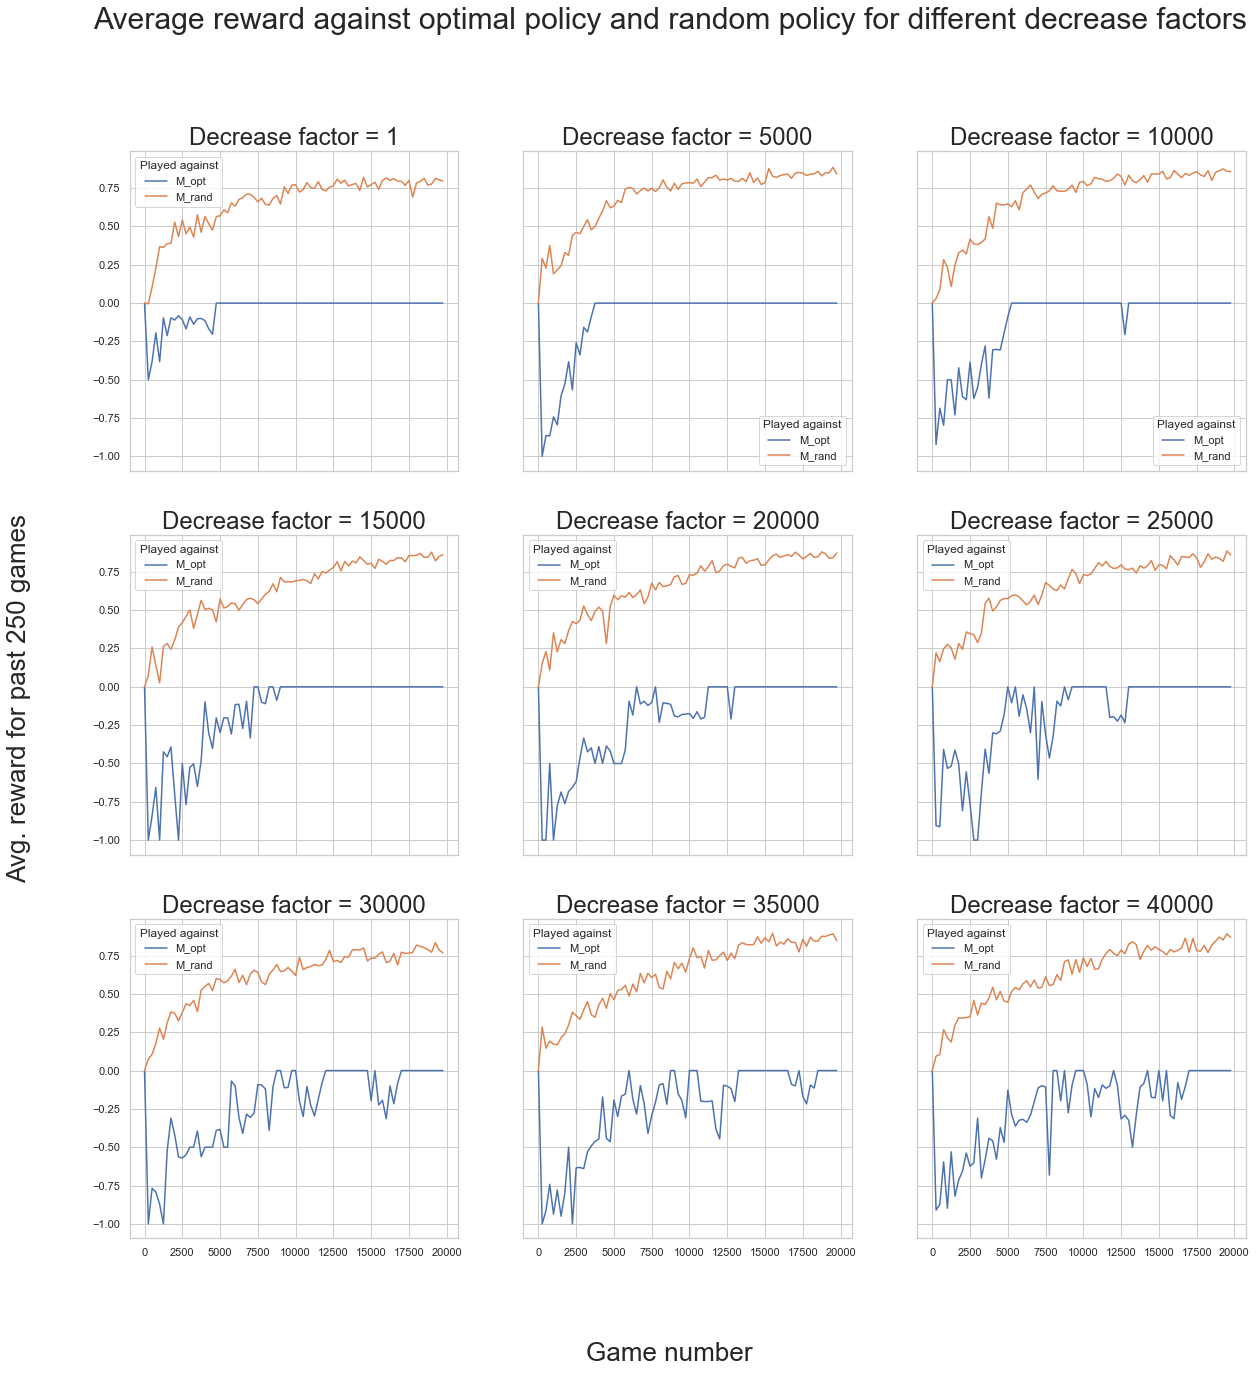

In [224]:
sns.set_theme(style='whitegrid')
x = np.linspace(0, 19750, 20000 // 250)

fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)
axs = axs.flatten()

# Reveal x-ticks and y-ticks on all subplots -> Doesnt work
for ax in axs:
    for (x_tick, y_tick) in zip(ax.get_xticklabels(), ax.get_yticklabels()):
        x_tick.set_visible(True)
        y_tick.set_visible(True)

# Plot
plt.suptitle('Average reward against optimal policy and random policy for different decrease factors', fontsize=30)
for i, (dec, (m_opt, m_rand)) in enumerate(zip(dec_factors, zip(m_opts, m_rands))):   
    sns.lineplot(x=x, y=m_opt, ax=axs[i])
    sns.lineplot(x=x, y=m_rand, ax=axs[i])
    axs[i].set_title(f'Decrease factor = {dec}', fontsize=24)
    axs[i].legend(title='Played against', labels=['M_opt', 'M_rand'], loc='lower right')

fig.text(0.5, 0.04, 'Game number', ha='center', fontsize=26)
fig.text(0.04, 0.5, 'Avg. reward for past 250 games', va='center', rotation='vertical', fontsize=26)
#plt.legend(title='Played against', labels=['M_opt', 'M_rand'])


In [ ]:
suptitle = 'Average reward against optimal policy and random policy for different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(3, 3, x, m, dec_factors, suptitle, xlabel, ylabel, labels=['M_opt', 'M_rand'], 
              legend_title='Played against', subtitle=subtitle)


### 2.1.2 Good experts and bad experts

Choosing $n^*$ = 20000 as this value yields the highest average reward after 20000 games.

We further pick ${\epsilon}_{opt}$ from $[0, 0.1, 0.2, 0.4, 0.6, 0.8]$. 

#### Question 4

In [308]:
e_opts = [0, 0.1, 0.2, 0.4, 0.6, 0.8]
m_opts, m_rands = [], []

for e_opt in e_opts:
    _, m_opt, m_rand = train(20000, e_opt=e_opt, dec_factor=20000, decrease_epsilon=True, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])


Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


In [309]:
suptitle = 'Average reward for best decreasing epsilon against optimal and random strategy'
subtitle = 'Epsilon for OptimalPlayer'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(3, 2, X, m, e_opts, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

TypeError: plot_subplots() got multiple values for argument 'subtitle'

#### Question 5

In [ ]:
max_m_opts = np.max(m_opts.reshape((m_opts.shape[0], m_opts.shape[2])))
max_m_rands = np.max(m_rands.reshape((m_rands.shape[0], m_rands.shape[2])))

print('The largest values of M_opt and M_rand are:')
print(f'M_opt: {max_m_opts}')
print(f'M_rand: {max_m_rands}')

#### Question 6

(Theory) Assume that Agent 1 learns by playing against Opt(0) and find the optimal Q- values Q1(s, a). In addition, assume that Agent 2 learns by playing against Opt(1) and find the optimal Q-values Q2(s, a). Do Q1(s, a) and Q2(s, a) have the same values? Justify your answer. (answer length < 150 words)

Agent 1 and Agent 2 will almost always have different values (or will they eventuelly converge to the same?). Opt(0) will always play an optimal strategy, whereas Opt(1) will play randomly. Therefore, Opt(1) will explore 